In [24]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt


In [25]:
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
cd /content/drive/MyDrive/files

/content/drive/MyDrive/files


In [28]:
ls

imdb_data.csv  iris.csv  Katze_wikipedia_images.jpg  Used_Car_Dataset.csv  yelp.csv


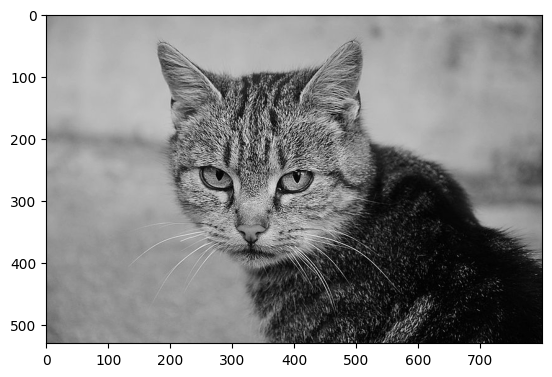

(530, 800)

In [29]:
img = cv2.imread("Katze_wikipedia_images.jpg", cv2.IMREAD_GRAYSCALE)/255
plt.imshow(img, cmap='gray')
plt.show()
img.shape

In [30]:
class Conv_op:
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)/(filter_size * filter_size)


    def image_region(self, image):
        height, width = image.shape
        self.image = image
        for j in range(height - self.filter_size + 1):
            for k in range(width - self.filter_size + 1):
                image_patch = image[j : (j + self.filter_size), k:(k + self.filter_size)]
                yield image_patch, j, k


    def forward_prop(self, image):
        height, width = image.shape
        conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters ))
        for image_patch, i, j in self.image_region(image):
            conv_out[i, j] = np.sum(image_patch * self.conv_filter, axis = (1,2))
        return conv_out


    def back_prop(self, dL_dout, learning_rate):
        dL_dF_params = np.zeros(self.conv_filter.shape)
        for image_patch, i, j in self.image_region(self.image):
            for k in range(self.num_filters):
                dL_dF_params[k] += image_patch*dL_dout[i,j,k]

        # Filter params update
        self.conv_filter -= learning_rate*dL_dF_params
        return dL_dF_params

In [31]:
conn = Conv_op(5, 3)
out = conn.forward_prop(img)
out.shape

(528, 798, 5)

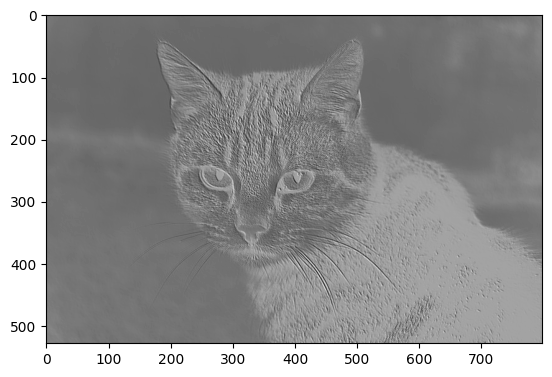

In [35]:
plt.imshow(out[:, :, 3], cmap = 'gray')
plt.show()

In [33]:
class Max_Pool:
    def __init(self, filter_size):
        self.filter_size = filter_size

    def image_region(self, image):
        new_height = image.shape[0] //self.filter_size
        new_width = image.shape[1] //self.filter_size
        self.image = image

        for i in range(new_height):
            for j in range(new_width):
                image_patch = image[(i * self.filter_size) : (i * self.filter_size + self.filter_size), (j * self.filter_size) : (j * self.filter_size + self.filter_size)]
                yield image_patch, i, j

    def forward_prop(self, image):
        height, widhth, num_filters = image.shape
        output = np.zeros((height // self.filter_size, widhth // self.filter_size, num_filters))

        for image_patch, i, j in self.image_region(image):
            output[i, j] = np.amax(image_patch, axis = (0, 1))

        return output

    def back_prop(self, dL_dout):
        dL_dmax_pool = np.zeros